# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import tree

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [3]:
os.listdir(path + 'cleaned')

['.DS_Store',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 '.ipynb_checkpoints']

## Pull in required data:

In [4]:
books = pd.read_csv(path + 'cleaned/BX-Books.csv')
users = pd.read_csv(path + 'cleaned/BX-Users.csv')
ratings = pd.read_csv(path + 'cleaned/BX-Ratings.csv')

In [5]:
books.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,clara callan by richard bruce wright,[0. 0. 0. ... 0. 0. 0.]


In [6]:
users.head(1)

,Unnamed: 0,User-ID,User-City,User-State,User-Country,User-Age,Age-Group
0,0,8,timmins,ontario,canada,44.0,1


In [7]:
ratings.head(1)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7


### TF-IDF for Book Info:

In [8]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')

In [9]:
tfidf_matrix = tf.fit(books['Book-Info'])

In [10]:
book_vector = tfidf_matrix.transform(books['Book-Info']).toarray()

In [11]:
books['Book-Vector'] = list(book_vector)

### Discretize ratings, year of published ...

array([[<Axes: title={'center': 'Book-Rating'}>]], dtype=object)

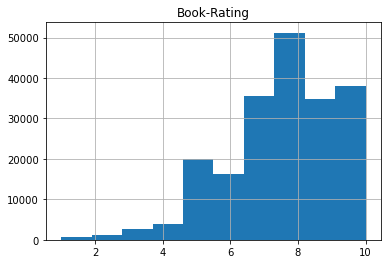

In [12]:
ratings.hist('Book-Rating')

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

In [98]:
encoder = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

In [99]:
ratings_discretized = encoder.fit_transform(ratings[['Book-Rating']])

In [100]:
encoder.bin_edges_

array([array([ 1.        ,  3.63532   ,  5.76491653,  7.79103102, 10.        ])],
      dtype=object)

In [101]:
ratings['Rating-Group'] = ratings_discretized.astype(int)

In [102]:
ratings['Rating-Group'].unique()

array([2, 3, 1, 0])

In [103]:
ratings

,User-ID,ISBN,Book-Rating,Rating-Group,Unnamed: 0,User-City,User-State,User-Country,User-Age,Age-Group
0,276744,038550120X,7,2,47901,torrance,california,usa,46.0,1
1,276754,0684867621,8,3,47902,alberta beach,alberta,canada,19.0,0
2,276755,0451166892,5,1,47903,frankfurt am main,hessen,germany,32.0,1
3,276788,0345443683,8,3,47906,mentone,california,usa,28.0,0
4,276788,043935806X,7,2,47906,mentone,california,usa,28.0,0
...,...,...,...,...,...,...,...,...,...,...
191717,276688,0892966548,10,3,47898,fort lee,new jersey,usa,32.0,1
191718,276688,1551669315,6,2,47898,fort lee,new jersey,usa,32.0,1
191719,276704,0345386108,6,2,47899,cedar park,texas,usa,27.0,0
191720,276704,0743211383,7,2,47899,cedar park,texas,usa,27.0,0


In [104]:
ratings = ratings.merge(users)

In [105]:
weighted_ratings = ratings.groupby(['ISBN', 'User-Country', 'Age-Group']).agg(average_rating 
                                     = ('Book-Rating', 'mean'), times_read = ('User-ID', 'count'), average_age = ('User-Age', 'mean')) \
                                    .reset_index()

In [151]:
m = 10
t = weighted_ratings['times_read']
a = weighted_ratings['average_rating']
c = ratings['Book-Rating'].mean()

In [152]:
weighted_ratings['weighted_ratings'] = ((t/(t+m))*a) + ((m/(m+t))*c)

In [153]:
weighted_ratings.sort_values('weighted_ratings', ascending = False)

,ISBN,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings
27158,0439139597,usa,0,9.522388,67,22.283582,9.288831
27127,0439136350,usa,0,9.370968,62,21.903226,9.142222
27233,043935806X,usa,0,9.281250,96,24.093750,9.134340
13035,0345339738,usa,0,9.475000,40,23.325000,9.124800
27143,0439136369,usa,0,9.287879,66,24.303030,9.082105
...,...,...,...,...,...,...,...
62296,0971880107,united kingdom,0,3.307692,13,22.538462,5.227827
62252,0971880107,australia,1,3.526316,19,37.947368,4.973794
62301,0971880107,usa,1,4.620370,108,38.787037,4.883390
62302,0971880107,usa,2,4.253333,75,56.906667,4.661647


In [109]:
books_ratings = books.merge(weighted_ratings)

In [129]:
encoder = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

In [130]:
average_ratings_discretized = encoder.fit_transform(books_ratings[['average_rating']])
weight_ratings_discretized = encoder.fit_transform(books_ratings[['weighted_ratings']])

In [132]:
encoder.bin_edges_

array([array([4.44459028, 7.32480774, 7.59800948, 7.82551933, 9.28883135])],
      dtype=object)

In [133]:
books_ratings['Average-Rating-Group'] = average_ratings_discretized.astype(int)
books_ratings['Weighted-Rating-Group'] = weight_ratings_discretized.astype(int)

In [134]:
decade_list = [1919 + 10 * x for x in range(10)]

In [135]:
books_ratings['Year-Of-Publication-Group'] = pd.cut(x=books_ratings['Year-Of-Publication'], bins=decade_list)

In [136]:
books_ratings.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Info,Book-Vector,User-Country,Age-Group,average_rating,times_read,average_age,weighted_ratings,Average-Rating-Group,Weighted-Rating-Group,Year-Of-Publication-Group
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,clara callan by richard bruce wright,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17,0,7.333333,3,25.666667,7.633847,2,2,"(1999, 2009]"


In [137]:
books_ratings.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Info', 'Book-Vector', 'User-Country',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'Average-Rating-Group', 'Weighted-Rating-Group',
       'Year-Of-Publication-Group'],
      dtype='object')

In [138]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(books_ratings[['User-Country']])
books_ratings[['User-Country']] = encoded.astype(int)

In [139]:
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(books_ratings[['Year-Of-Publication-Group']])
books_ratings[['Year-Of-Publication-Group']] = encoded.astype(int)

In [140]:
X = books_ratings[['Book-Info', 'User-Country', 'Age-Group', 'Year-Of-Publication-Group']]
y = books_ratings['Average-Rating-Group']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [142]:
X_train.head(1)

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
16799,name by jose saramago,111,2,8


In [143]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer())
])


# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group', 'Year-Of-Publication-Group']),
    ('country', 'passthrough', ['User-Country'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group',
                                                   'Year-Of-Publication-Group']),
                                                 ('country', 'passthrough',
                                                  ['User-Country'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [144]:
y_pred = pipeline.predict(X_test)

In [145]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4944926690495295


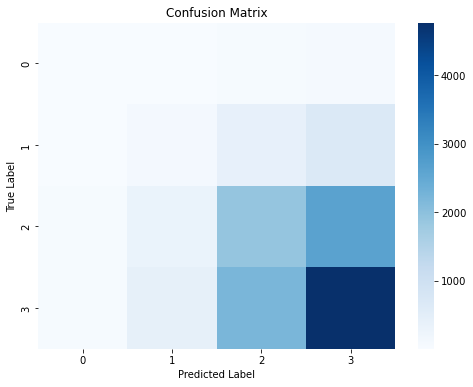

In [146]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='%d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [147]:
cm

array([[   1,   15,   54,   81],
       [  10,  108,  408,  680],
       [  41,  314, 1897, 2643],
       [  46,  421, 2217, 4773]])

In [128]:
X

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
0,clara callan by richard bruce wright,17,0,8
1,clara callan by richard bruce wright,17,1,8
2,clara callan by richard bruce wright,17,2,8
3,flu story great influenza pandemic 1918 search...,111,0,7
4,flu story great influenza pandemic 1918 search...,111,1,7
...,...,...,...,...
68539,ice house tv tie edition by minette walters,104,2,7
68540,trouble business vintage crime black lizard by...,17,0,7
68541,trouble business vintage crime black lizard by...,111,0,7
68542,trouble business vintage crime black lizard by...,111,1,7


In [55]:
example_dict = {'Book-Info':'harry potter by jk rowling',
                          'User-Country':111, 'Age-Group':1, 'Year-Of-Publication-Group':8}
example_dict

{'Book-Info': 'harry potter by jk rowling',
 'User-Country': 111,
 'Age-Group': 1,
 'Year-Of-Publication-Group': 8}

In [56]:
X_example = pd.DataFrame(example_dict, index = [0])

In [57]:
X_example

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
0,harry potter by jk rowling,111,1,8


In [58]:
pipeline.predict(X_example)

array([2])